In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import densenet121, resnet18
import torch.nn as nn
import torch.optim as optim

selected_folders = 'images_001|images_002|images_003|images_004|images_005'

# Load and filter data
data = pd.read_csv('./data/Data_Entry_2017.csv')
data = data[data['Patient Age'] < 100]  # Removing invalid ages
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join('.', 'data', 'images*', '*', '*.png'))}
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].astype(int)
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
mask = data['path'].str.contains(selected_folders)
data = data[mask]
# print(data['path'])


# Process labels
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if x]
for label in all_labels:
    if len(label) > 1:  # Avoid empty labels
        data[label] = data['Finding Labels'].map(lambda findings: 1.0 if label in findings else 0)

# Filter labels to keep
MIN_CASES = 1000
all_labels = [label for label in all_labels if data[label].sum() > MIN_CASES]
data['disease_vec'] = data[all_labels].values.tolist()

# Print information
print(f"Clean Labels ({len(all_labels)}): {[(label, int(data[label].sum())) for label in all_labels]}")
print('Scans found:', len(data_image_paths), ', Total Headers:', data.shape[0])

Clean Labels (9): [('Atelectasis', 4378), ('Cardiomegaly', 1206), ('Consolidation', 1707), ('Effusion', 4584), ('Infiltration', 6716), ('Mass', 1855), ('Nodule', 2235), ('Pleural_Thickening', 1312), ('Pneumothorax', 1879)]
Scans found: 112120 , Total Headers: 44998


In [2]:
data[['Image Index', 'path']]

,Image Index,path
0,00000001_000.png,./data/images_001/images/00000001_000.png
1,00000001_001.png,./data/images_001/images/00000001_001.png
2,00000001_002.png,./data/images_001/images/00000001_002.png
3,00000002_000.png,./data/images_001/images/00000002_000.png
4,00000003_000.png,./data/images_001/images/00000003_000.png
...,...,...
44994,00011558_003.png,./data/images_005/images/00011558_003.png
44995,00011558_004.png,./data/images_005/images/00011558_004.png
44996,00011558_005.png,./data/images_005/images/00011558_005.png
44997,00011558_006.png,./data/images_005/images/00011558_006.png


In [3]:
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, image_paths, labels, transform=None):
        self.dataframe = dataframe
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['path']
        image = Image.open(image_path).convert('RGB')
        label = torch.tensor(self.dataframe.iloc[idx][self.labels].astype(float).values)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.20, random_state=2018, stratify=data['Finding Labels'].str[:4])
train_df, valid_df = train_test_split(train_df, test_size=0.10, random_state=2018, stratify=train_df['Finding Labels'].str[:4])

# Create DataLoaders
train_dataset = ChestXrayDataset(train_df, data_image_paths, all_labels, transform=transform)
valid_dataset = ChestXrayDataset(valid_df, data_image_paths, all_labels, transform=transform)
test_dataset = ChestXrayDataset(test_df, data_image_paths, all_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [26]:
from torchvision import models
class ViT(nn.Module):
    def __init__(self, num_classes):
        super(ViT, self).__init__()
        self.model = models.vit_b_32(pretrained = False)
        self.model.heads.head = nn.Linear(768, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        features = self.model(x)
        return self.sigmoid(features)

class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.model = models.resnet18(pretrained = False)
        self.model.fc = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        features = self.model(x)
        return self.sigmoid(features)

class CNNViT(nn.Module):
    def __init__(self, num_classes):
        super(CNNViT, self).__init__()
        self.model1 = models.resnet18(pretrained = False)
        self.model1.fc = nn.Linear(512, 512)
        self.model2 = models.vit_b_32(pretrained = False)
        self.model2.heads.head = nn.Linear(768, 512)
        self.classifier = nn.Sequential(nn.Linear(1024, 512), 
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes),
                                        nn.Sigmoid())

    def forward(self, x):
#         print(x.shape)
#         features = self.features(x)
        features1 = self.model1(x)
        features2 = self.model1(x)
        features = torch.concat([features1, features2], dim=1)
        out = self.classifier(features)
        return out

model = CNNViT(len(all_labels))
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.BCELoss()
print(model)

/home/sakib/anaconda3/envs/dl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sakib/anaconda3/envs/dl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


CNNViT(
  (model1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [27]:
from tqdm import tqdm
# Training and Validation Loop
def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train_loss = 0.0
        total_correct = 0
        total_samples = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
#             print(images.shape)
            outputs = model(images)
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            # Count correct predictions
            correct = (predicted == labels).all(dim=1).sum().item()
            total_correct += correct

            # Increment total number of samples
            total_samples += labels.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        train_accuracy = total_correct / total_samples * 100
        
        # Validation Phase
        model.eval()
        total_valid_loss = 0.0
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs.float(), labels.float())
                total_valid_loss += loss.item()
                
                predicted = (outputs > 0.5).float()
                # Count correct predictions
                correct = (predicted == labels).all(dim=1).sum().item()
                total_correct += correct

                # Increment total number of samples
                total_samples += labels.size(0)

        avg_valid_loss = total_valid_loss / len(valid_loader)
        val_loss.append(avg_valid_loss)
        val_accuracy = total_correct / total_samples * 100
        
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Validation Loss: {avg_valid_loss:.4f}')
        print(train_accuracy, val_accuracy)
        
    return train_loss, val_loss

# Continue with model training
train_and_validate(model.cuda(), train_loader, valid_loader, criterion, optimizer, num_epochs=1)

100%|███████████████████████████████████████████| 57/57 [00:41<00:00,  1.37it/s]

Epoch [1/1], Train Loss: 0.2697, Validation Loss: 0.2150
58.94808321501327 60.5


([0.26970162476308246], [0.21500026395446376])

In [ ]:
gc.collect()

In [ ]:
import gc

In [ ]:
torch.cuda.empty_cache()

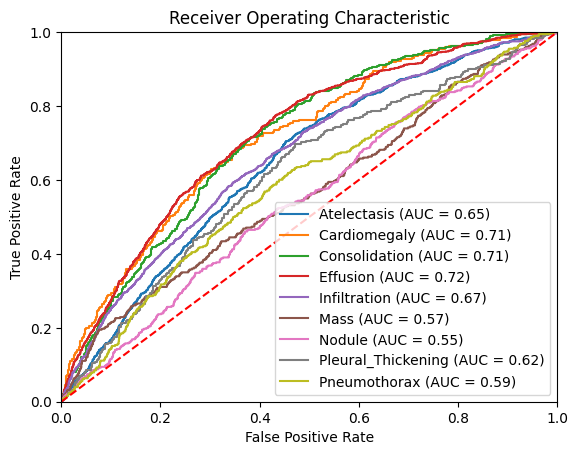

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to compute the ROC AUC score
def compute_roc_auc(model, data_loader, num_classes):
    model.eval()
    y_true = torch.FloatTensor().cuda()
    y_pred = torch.FloatTensor().cuda()
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            y_true = torch.cat((y_true, labels), 0)
            y_pred = torch.cat((y_pred, outputs), 0)

    roc_auc_dict = {}
    for i, label in enumerate(all_labels):
        fpr, tpr, _ = roc_curve(y_true.cpu()[:, i], y_pred.cpu()[:, i])
        roc_auc_dict[label] = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
    
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return roc_auc_dict

# Compute and plot ROC AUC
roc_auc_scores = compute_roc_auc(model, test_loader, len(all_labels))

In [12]:
print(roc_auc_scores)

{'Atelectasis': 0.5661641142857143, 'Cardiomegaly': 0.5951724379072018, 'Consolidation': 0.6567173430960135, 'Effusion': 0.5669571057422103, 'Infiltration': 0.6274382984726781, 'Mass': 0.5063921113689096, 'Nodule': 0.5583769927804061, 'Pleural_Thickening': 0.5383318347317325, 'Pneumothorax': 0.5679501742190214}


In [ ]:
# Visualization of Predictions
def visualize_predictions(model, data_loader, num_images=4):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.cuda(), labels.cuda()
    outputs = model(images)
    outputs = outputs > 0.5  # Threshold predictions

    fig, axs = plt.subplots(1, num_images, figsize=(15, 10))
    for i in range(num_images):
        axs[i].imshow(images[i].cpu().permute(1, 2, 0))
        axs[i].axis('off')
        disease_labels = ', '.join([all_labels[j] for j in range(outputs.shape[1]) if outputs[i, j] == 1])
        axs[i].set_title(disease_labels)

    plt.show()

# Call visualization function
visualize_predictions(model, test_loader, num_images=4)

## Gated Features Probing (W/T Attention)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class ModifiedViT(nn.Module):
    """
    Modified Vision Transformer that returns both the output features and the attention weights
    from the last self-attention layer for use in feature fusion and probing.
    """
    def __init__(self):
        super(ModifiedViT, self).__init__()
        self.base_vit = models.vit_b_32(pretrained=True)
        self.base_vit.heads.head = nn.Identity()  # Remove the classification head

    def forward(self, x):
        # Extract intermediate features and attention weights
        # Assuming the ViT model has been modified to allow fetching these details
        # This requires accessing named modules within the ViT architecture
        features, attn_weights = self.base_vit.get_intermediate_layers(x, n=1)
        return features[-1], attn_weights[-1]  # Return last layers' features and attention weights

class AdaptiveFeatureFusion(nn.Module):
    """
    Adaptive Feature Fusion Module using attention weights from ViT to enhance feature integration.
    This module uses learned gates to combine features from two different models (e.g., CNN and ViT).
    """
    def __init__(self, feature_dim):
        super(AdaptiveFeatureFusion, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.Sigmoid()
        )
    
    def forward(self, features_cnn, features_vit, attention_weights):
        # Use attention weights to calculate gated features
        # Assumes attention_weights are pre-processed to match feature dimensions
        gated_weights = self.gate(attention_weights.squeeze(-1))  # Squeeze if attention has extra dimensions
        combined_features = features_cnn * gated_weights + features_vit * (1 - gated_weights)
        return combined_features

class EnhancedCNNViT(nn.Module):
    """
    Enhanced model combining ResNet and Vision Transformer with adaptive feature fusion
    using the attention mechanism from ViT for improved feature utilization.
    """
    def __init__(self, num_classes):
        super(EnhancedCNNViT, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 512)  # Adjusting the final layer

        self.vit = ModifiedViT()  # Using the modified ViT that returns attention details

        self.feature_fusion = AdaptiveFeatureFusion(512)  # Fusion module for ResNet and ViT features
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),  # Combine and reduce dimension
            nn.ReLU(),
            nn.Linear(512, num_classes),  # Final classification layer
            nn.Sigmoid()
        )

    def forward(self, x):
        resnet_features = self.resnet(x)
        vit_features, attention_weights = self.vit(x)  # Get features and attention weights from ViT

        # Fuse features using the adaptive fusion module
        combined_features = self.feature_fusion(resnet_features, vit_features, attention_weights)
        output = self.classifier(combined_features)
        return output

# Example usage
model = EnhancedCNNViT(num_classes=len(all_labels))  # Assuming 10 classes for the task
print(model)  # Printing model summary to understand its structure

# Optional: Summary with input size specification (requires torchsummary)
from torchsummary import torchsummary
torchsummary.summary(model, input_size=(3, 224, 224), device='cpu')  # or 'cuda' if using GPU

## Iterative Neuron Probing (W/O Attention)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class NeuronProber(nn.Module):
    """
    Module to adaptively adjust neuron contributions based on their activation strengths.
    """
    def __init__(self, num_features, num_classes):
        super(NeuronProber, self).__init__()
        self.num_features = num_features
        self.num_classes = num_classes
        self.probe_weights = nn.Parameter(torch.rand(num_classes, num_features))

    def forward(self, features):
        # Normalize probe weights
        normalized_weights = torch.sigmoid(self.probe_weights)
        
        # Adjust features based on class-specific probe weights
        class_specific_features = features.unsqueeze(1).repeat(1, self.num_classes, 1) * normalized_weights.unsqueeze(0)
        max_activated_features = torch.max(class_specific_features, dim=2)[0]
        
        return max_activated_features

class EnhancedCNNViT(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNNViT, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Use the feature extractor part only

        self.vit = models.vit_b_32(pretrained=True)
        self.vit.heads.head = nn.Identity()  # Use the feature extractor part only

        self.feature_dim = 512 + 768  # Assuming 512 from ResNet and 768 from ViT
        self.prober = NeuronProber(self.feature_dim, num_classes)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        resnet_features = self.resnet(x)
        vit_features = self.vit(x)
        
        # Concatenate features from both models
        combined_features = torch.cat((resnet_features, vit_features), dim=1)
        
        # Probe and enhance features
        enhanced_features = self.prober(combined_features)
        
        # Final classification
        output = self.classifier(enhanced_features)
        return output

model = EnhancedCNNViT(num_classes=len(all_labels))

### Train/Validation Loop

In [ ]:
# Training and Validation Loop
def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20):
    model.cuda()
    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_valid_loss = 0, 0
        total_train_correct, total_valid_correct = 0, 0
        total_train_samples, total_valid_samples = 0, 0

        # Training
        for images, labels in tqdm(train_loader):
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            # Calculating accuracy
            predicted = outputs.round()
            total_train_correct += (predicted == labels).all(dim=1).sum().item()
            total_train_samples += labels.size(0)

        # Validation
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()

                # Calculating accuracy
                predicted = outputs.round()
                total_valid_correct += (predicted == labels).all(dim=1).sum().item()
                total_valid_samples += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_valid_loss = total_valid_loss / len(valid_loader)
        train_accuracy = (total_train_correct / total_train_samples) * 100
        valid_accuracy = (total_valid_correct / total_valid_samples) * 100

        print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {valid_accuracy:.2f}%')

# Free up memory
gc.collect()
torch.cuda.empty_cache()

# Call training/validation function
train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20)

# ROC AUC Calculation
compute_roc_auc(model, test_loader, len(all_labels))